In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

# Functions for Preprocessing & Scaling Data

In [78]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Run the code again to define and test the Min-Max scaling functions
# Define the function for Min-Max scaling
def min_max_scaling(data):
    """
    Normalize the data using Min-Max scaling.
    Args:
    - data (DataFrame): The data to normalize

    Returns:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column
    """
    scaling_params = {}
    normalized_data = data.copy()

    for column in data.columns:
        min_val = data[column].min()
        max_val = data[column].max()
        scaling_params[column] = {'min': min_val, 'max': max_val}
        normalized_data[column] = (data[column] - min_val) / (max_val - min_val)

    return normalized_data, scaling_params

# Define the function for inverse Min-Max scaling
def inverse_min_max_scaling(normalized_data, scaling_params):
    """
    Reverse the Min-Max scaling to get the original data.
    Args:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column

    Returns:
    - original_data (DataFrame): The data in its original scale
    """
    original_data = normalized_data.copy()

    for idx, column in enumerate(normalized_data.columns):
        # Convert integer column names to string to match with scaling_params keys
        key = str(column) if isinstance(column, int) else column
        keys = list(scaling_params.keys())
        min_val = scaling_params[keys[int(key)]]['min']
        max_val = scaling_params[keys[int(key)]]['max']
        original_data[column] = normalized_data[column] * (max_val - min_val) + min_val

    return original_data

# Outlier Handling Functions

**Replace outliers for each weekday and each time slot with median for that slot and weekday**

In [79]:
def outlier_handler(data):
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extract day of the week and time from the 'date' column
    data['day_of_week'] = data['date'].dt.day_name()
    data['time'] = data['date'].dt.time

    # Define a function to replace outliers with median for each group
    def replace_outliers(group):
        # Iterate over each column in the group
        for col in group.columns:
            if col not in ['date', 'day_of_week', 'time']:
                # Compute the IQR
                Q1 = group[col].quantile(0.25)
                Q3 = group[col].quantile(0.75)
                IQR = Q3 - Q1

                # Define bounds for outliers
                lower_bound = Q1 - 0.75 * IQR
                upper_bound = Q3 + 0.75 * IQR

                # Replace outliers with median of the group
                median_val = group[col].median()
                group[col] = group[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

        return group

    # Group by 'day_of_week' and 'time' and apply the function to replace outliers
    data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)
    data = data.drop(columns=['day_of_week','time'])

    return data

# Function for Handling Zero Points

In [80]:
def zero_handler(data, range):
    data['date'] = pd.to_datetime(data['date'])
    data['weekday'] = data['date'].dt.dayofweek
    data['time'] = data['date'].dt.time

    # Loop over each segment column
    for col in data.columns[1:-2]:
        # Group by weekday and time slot
        grouped = data.groupby(['weekday', 'time'])

        # Define a function to apply to each group
        def replace_zeros(group):
            nonzero_mean = group[group != 0].mean()
            if pd.notnull(nonzero_mean):
                return group.replace(0, nonzero_mean)
            else:
                return group

        # Apply the function to each group in the specific segment column
        data[col] = grouped[col].transform(replace_zeros)

    data = data.drop(columns=['weekday','time'])

    return handle_zeros_with_rolling_mean(data, range)

In [81]:
def handle_zeros_with_rolling_mean(data, range):
    for col in data.columns[1:]:
        mv_avg = data[col].rolling(range).mean()
        for i, val in enumerate(data[col]):
            if val == 0:
                data.loc[i,col] = mv_avg[i]
    data = data.tail(-(range))
    return data

# Function for Converting data into sequential data

**Get a matrix of 8 hour window as X and its next step values as Y**

In [82]:
def formatting_features_targets(data_values, window_size, step_i,dates):
    # Preprocessing and reshaping data
    num_sequences = len(data_values) - window_size
    X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
    y = np.array([data_values[i+window_size+step_i-1] for i in range(num_sequences)])
    d = np.array([dates[i+window_size+step_i-1] for i in range(num_sequences)])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    return X, y,d

# Transformer Model

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatioTemporalModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dropout_rate=0.1):
        super(SpatioTemporalModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        # self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        # self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutional layers
        self.flattened_size = (input_size[1] // 4) * (input_size[2] // 4) * 32  # Dividing by 4 due to two pooling layers
        # Bottleneck layer to adjust the dimensionality to d_model
        self.bottleneck = nn.Linear(self.flattened_size, d_model)

        # Transformer layers
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_rate
        )

        # Linear layer for prediction
        self.fc1 = nn.Linear(d_model, d_model//2)
        self.fc2 = nn.Linear(d_model//2, d_model//4)
        self.fc3 = nn.Linear(d_model//4, output_size)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flattening
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)

        # Transformer layers
        x = x.unsqueeze(0)
        x = self.transformer(x, x)
        x = x.squeeze(0)

        # Linear layer for prediction
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x

# Placing Data into Torch Tensors Functions

In [84]:
def get_torch_tensor(df, device):
    return torch.tensor(df, dtype=torch.float32).to(device)

def get_train_val_test_loaders(X_scaled, y_scaled, val_fraction, test_fraction, device, batch_size, dates):
    test_splitter = round(len(X_scaled)*(1-test_fraction))
    X_train_val_scaled , X_test_scaled = X_scaled[:test_splitter] , X_scaled[test_splitter:]
    y_train_val_scaled , y_test_scaled = y_scaled[:test_splitter] , y_scaled[test_splitter:]
    dates_train_val_scaled , dates_test_scaled = dates[:test_splitter] , dates[test_splitter:]

    train_val_splitter = round(len(X_train_val_scaled)*(1-val_fraction))
    X_train_scaled , X_val_scaled = X_train_val_scaled[:train_val_splitter] , X_train_val_scaled[train_val_splitter:]
    y_train_scaled , y_val_scaled = y_train_val_scaled[:train_val_splitter] , y_train_val_scaled[train_val_splitter:]
    dates_train_scaled , dates_val_scaled = dates_train_val_scaled[:train_val_splitter] , dates_train_val_scaled[train_val_splitter:]

    X_train_tensor = get_torch_tensor(X_train_scaled, device)
    y_train_tensor = get_torch_tensor(y_train_scaled, device)
    X_val_tensor = get_torch_tensor(X_val_scaled, device)
    y_val_tensor = get_torch_tensor(y_val_scaled, device)
    X_test_tensor = get_torch_tensor(X_test_scaled, device)
    y_test_tensor = get_torch_tensor(y_test_scaled, device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, dates_test_scaled


In [85]:
def training(model, train_loader, val_loader):
    # Training loop with tqdm progress bar
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs = 15
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_val_loss+=loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Error Metrics Functions

## For Overall

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluateModel(model, val_loader, device, scaling_params=None):
    """
    Evaluate the model and return MSE, RMSE, and MAE.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - mse (float): Mean Squared Error
    - rmse (float): Root Mean Squared Error
    - mae (float): Mean Absolute Error
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    mse = mean_squared_error(all_true_values, all_predictions)
    rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
    mae = mean_absolute_error(all_true_values, all_predictions)

    return mse, rmse, mae,all_predictions,all_true_values

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


## Errors by Segment

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Let's update the evaluate_model_per_segment function to compute MSE, RMSE, and MAE for each segment
def evaluate_model_per_segment(model, val_loader, device, scaling_params=None):
    """
    Evaluate the model for each segment and return metrics.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - segment_metrics (dict): Metrics (MSE, RMSE, MAE) for each segment
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    num_segments = all_predictions.shape[1]
    segment_metrics = {}

    from sklearn.metrics import mean_absolute_error
    overall_mae = mean_absolute_error(all_predictions, all_true_values)
    print(f"Overall Error Metrics ==> MAE : {overall_mae}")

    # Calculate MSE, RMSE, and MAE for each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        mse = np.mean((segment_predictions - segment_true_values)**2)
        rmse = np.sqrt(mse)
        # mae = np.mean(np.abs(segment_predictions - segment_true_values))
        mae = mean_absolute_error(segment_predictions, segment_true_values)

        segment_metrics[f"Segment {segment_idx+1}"] = {"MSE": mse, "RMSE": rmse, "MAE": mae}

    return segment_metrics

def evaluate_segments(model, test_loader, device, scaling_params=None):
    segment_metrics = evaluate_model_per_segment(model, test_loader, device, scaling_params)

    # Display metrics for each segment
    for segment, metrics in segment_metrics.items():
        print(f"{segment} => MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")


## Visualizing Performance of Model against each segment

In [88]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Update the visualize_sorted_predictions function to reverse the normalization
def visualize_sorted_predictions(model, val_loader, device, scaling_params=None):
    """
    Visualize the sorted predictions and true values in their original scale.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    num_segments = all_predictions.shape[1]
    # print(inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params))

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    # Plotting each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        # Sorting the actual values and adjusting predictions accordingly
        # sorted_indices = np.argsort(segment_true_values)
        # sorted_true_values = segment_true_values[sorted_indices]
        # sorted_predictions = segment_predictions[sorted_indices]

        # sorted_indices = np.argsort(segment_true_values)
        sorted_true_values = segment_true_values
        sorted_predictions = segment_predictions

        plt.figure(figsize=(12, 6))
        plt.plot(sorted_true_values, label="Actual Values", color='blue')
        plt.plot(sorted_predictions, label="Predicted Values", color='red')
        plt.title(f"Segment {segment_idx+1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.show()


# Obtainig GPU CUDA

In [89]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the Data

In [90]:
# timestep used for data
minutes = 5

In [91]:
# Load the dataset
orig_df = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/datasets/avg_run_{minutes}min_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_run_{minutes}min_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1.csv')

# orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

In [92]:
orig_df.rename(columns={'datetime': 'date'}, inplace=True)


In [93]:
orig_df.loc[len(orig_df)-1]

date    2022-11-01 18:55:00
1                       0.0
2                       0.0
3                       0.0
4                       0.0
5                       0.0
6                       0.0
7                       0.0
8                       0.0
9                       0.0
10                      0.0
11                      0.0
12                      0.0
13                      0.0
14                    101.0
15                    320.0
Name: 42431, dtype: object

# Applying the ML Process

In [94]:
zero_handle_range = int((15/minutes)*6)
data2 = orig_df
# data2 = outlier_handler(orig_df)
data2 = zero_handler(data2, zero_handle_range)
timeslots = data2['date'].values
data2 = data2.drop(columns=['date'])

data2, scaling_params2 = min_max_scaling(data2)
data_values2 = data2.values

window_size = int(8/(minutes/60))
step_i = 1
X2, y2, times = formatting_features_targets(data_values2, window_size, step_i,timeslots)

In [95]:
d_model = 512
batchSize = 64
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2

In [96]:
# Initialize the model
model2 = SpatioTemporalModel(input_size=X2.shape[1:], output_size=y2.shape[1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [97]:
train_loader2, val_loader2, test_loader2, dates_test = get_train_val_test_loaders(X2, y2, 0.02, 0.13, device, batchSize, times)

In [98]:
model2.to(device)
training(model2, train_loader2, val_loader2)

Epoch 1 Validation: 100%|██████████| 12/12 [00:00<00:00, 179.57it/s]


Epoch [1/15] => Train Loss: 0.0099, Val Loss: 0.0106


Epoch 2 Validation: 100%|██████████| 12/12 [00:00<00:00, 193.82it/s]


Epoch [2/15] => Train Loss: 0.0094, Val Loss: 0.0105


Epoch 3 Validation: 100%|██████████| 12/12 [00:00<00:00, 121.21it/s]


Epoch [3/15] => Train Loss: 0.0092, Val Loss: 0.0103


Epoch 4 Validation: 100%|██████████| 12/12 [00:00<00:00, 131.09it/s]


Epoch [4/15] => Train Loss: 0.0087, Val Loss: 0.0044


Epoch 5 Validation: 100%|██████████| 12/12 [00:00<00:00, 167.86it/s]


Epoch [5/15] => Train Loss: 0.0027, Val Loss: 0.0030


Epoch 6 Validation: 100%|██████████| 12/12 [00:00<00:00, 176.97it/s]


Epoch [6/15] => Train Loss: 0.0024, Val Loss: 0.0029


Epoch 7 Validation: 100%|██████████| 12/12 [00:00<00:00, 166.52it/s]


Epoch [7/15] => Train Loss: 0.0023, Val Loss: 0.0027


Epoch 8 Validation: 100%|██████████| 12/12 [00:00<00:00, 154.13it/s]


Epoch [8/15] => Train Loss: 0.0022, Val Loss: 0.0026


Epoch 9 Validation: 100%|██████████| 12/12 [00:00<00:00, 181.00it/s]


Epoch [9/15] => Train Loss: 0.0021, Val Loss: 0.0026


Epoch 10 Validation: 100%|██████████| 12/12 [00:00<00:00, 165.80it/s]


Epoch [10/15] => Train Loss: 0.0013, Val Loss: 0.0013


Epoch 11 Validation: 100%|██████████| 12/12 [00:00<00:00, 111.23it/s]


Epoch [11/15] => Train Loss: 0.0008, Val Loss: 0.0013


Epoch 12 Validation: 100%|██████████| 12/12 [00:00<00:00, 124.80it/s]


Epoch [12/15] => Train Loss: 0.0007, Val Loss: 0.0013


Epoch 13 Validation: 100%|██████████| 12/12 [00:00<00:00, 166.34it/s]


Epoch [13/15] => Train Loss: 0.0007, Val Loss: 0.0013


Epoch 14 Validation: 100%|██████████| 12/12 [00:00<00:00, 185.29it/s]


Epoch [14/15] => Train Loss: 0.0007, Val Loss: 0.0012


Epoch 15 Validation: 100%|██████████| 12/12 [00:00<00:00, 183.62it/s]

Epoch [15/15] => Train Loss: 0.0006, Val Loss: 0.0013


In [99]:
mse2, rmse2, mae2, pred, trueVal = evaluateModel(model2, test_loader2, device, scaling_params2)
print(f"MSE: {mse2:.4f}, RMSE: {rmse2:.4f}, MAE: {mae2:.4f}")
# v1 - MSE: 1747.1942, RMSE: 33.6750, MAE: 25.9307
# v3 - MSE: 1448.6693, RMSE: 31.2468, MAE: 23.5870
# v4 - MSE: 2346.4839, RMSE: 37.4656, MAE: 30.4317 batch size = 1

# 10 min - MSE: 404.0626, RMSE: 16.7137, MAE: 10.1751
# 5  min - MSE: 107.9190, RMSE: 8.8442, MAE: 2.0576
# 15 min - MSE: 478.6729, RMSE: 18.7366, MAE: 12.1529

# with zerohandler
#  5 min - MSE: 165.3000, RMSE: 11.0085, MAE: 5.8335

MSE: 642.7094, RMSE: 22.5810, MAE: 13.4822


In [100]:
evaluate_segments(model2, test_loader2, device, scaling_params2)


Overall Error Metrics ==> MAE : 13.482199668884277
Segment 1 => MSE: 265.2571, RMSE: 16.2867, MAE: 10.1877
Segment 2 => MSE: 1405.6974, RMSE: 37.4926, MAE: 22.3831
Segment 3 => MSE: 1956.4771, RMSE: 44.2321, MAE: 28.6284
Segment 4 => MSE: 415.0277, RMSE: 20.3722, MAE: 13.3249
Segment 5 => MSE: 171.2672, RMSE: 13.0869, MAE: 9.0253
Segment 6 => MSE: 1678.4592, RMSE: 40.9690, MAE: 21.6304
Segment 7 => MSE: 102.1868, RMSE: 10.1087, MAE: 6.1408
Segment 8 => MSE: 96.4617, RMSE: 9.8215, MAE: 5.6487
Segment 9 => MSE: 55.4706, RMSE: 7.4479, MAE: 4.9117
Segment 10 => MSE: 444.0646, RMSE: 21.0728, MAE: 12.1585
Segment 11 => MSE: 1115.2834, RMSE: 33.3959, MAE: 19.3274
Segment 12 => MSE: 293.6037, RMSE: 17.1349, MAE: 11.0771
Segment 13 => MSE: 256.6356, RMSE: 16.0199, MAE: 9.2962
Segment 14 => MSE: 388.4410, RMSE: 19.7089, MAE: 10.3252
Segment 15 => MSE: 996.3079, RMSE: 31.5643, MAE: 18.1675


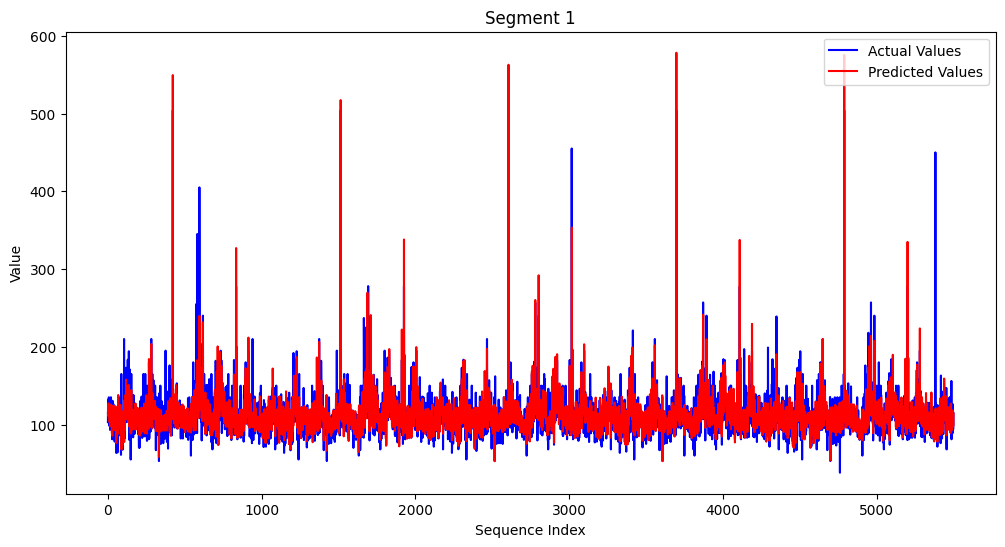

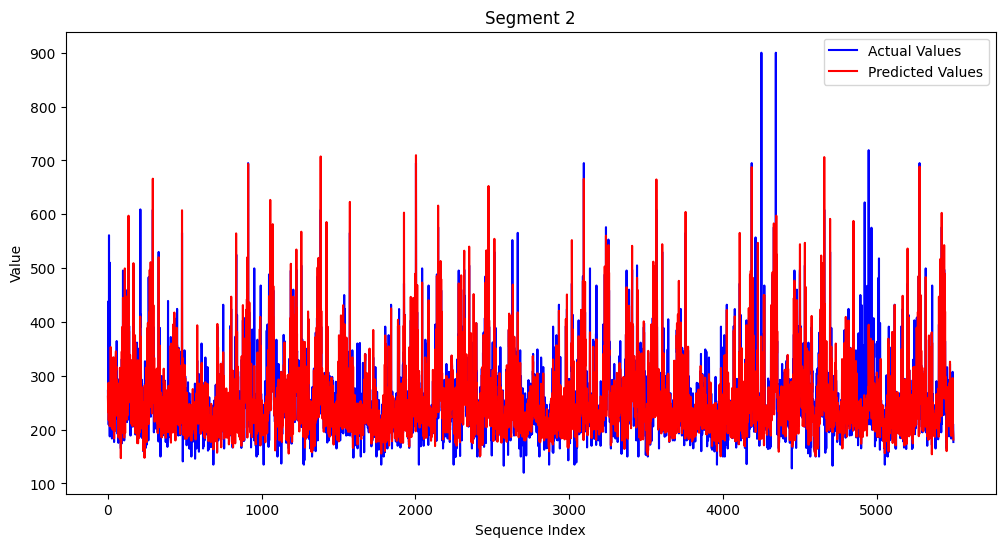

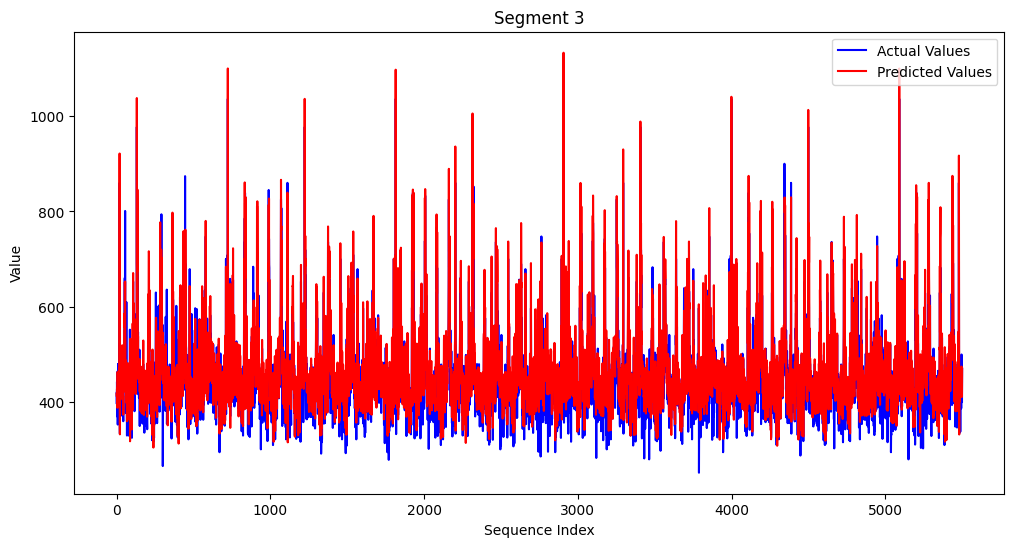

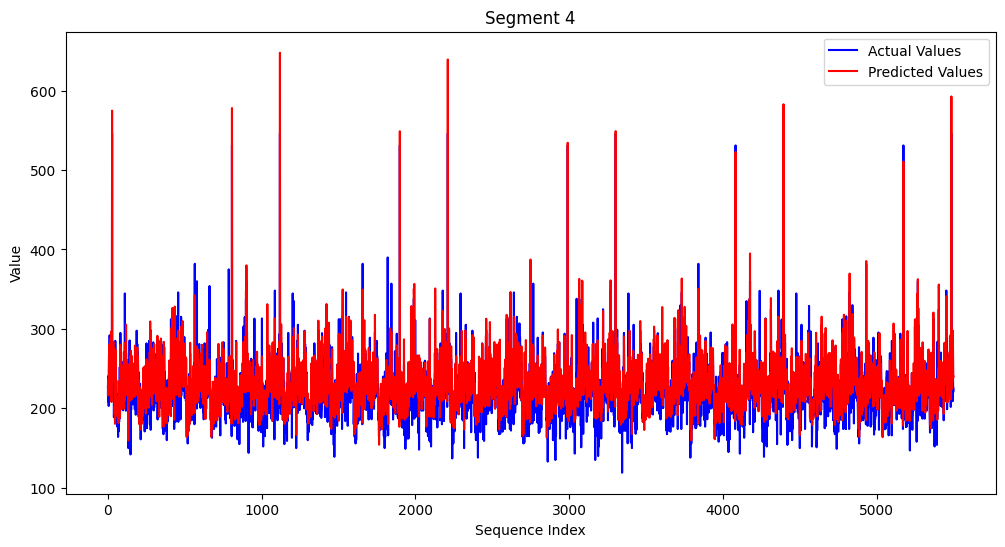

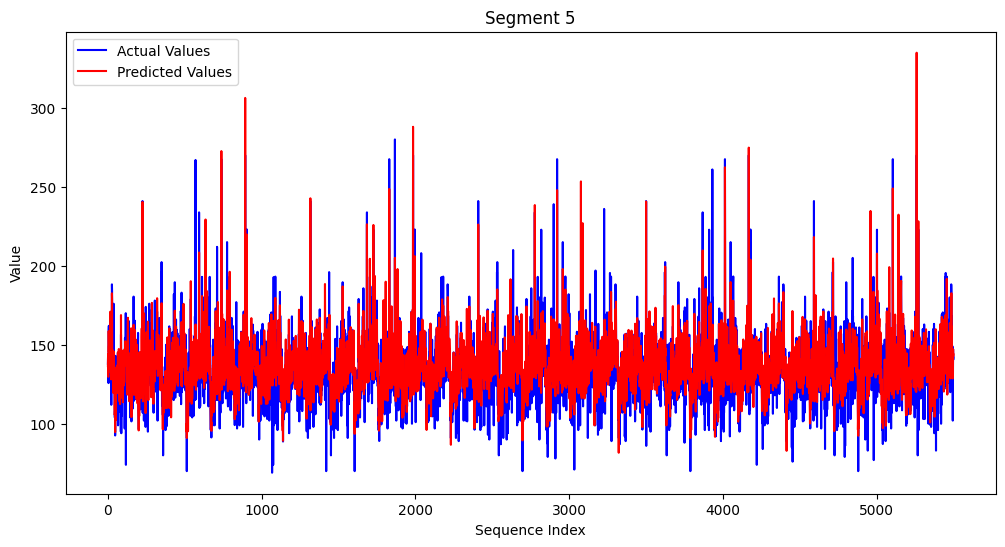

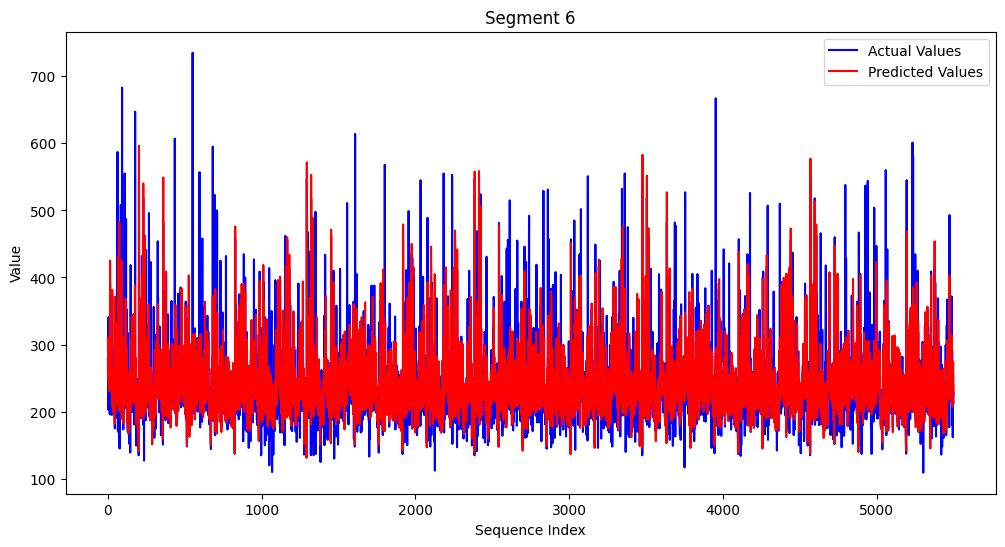

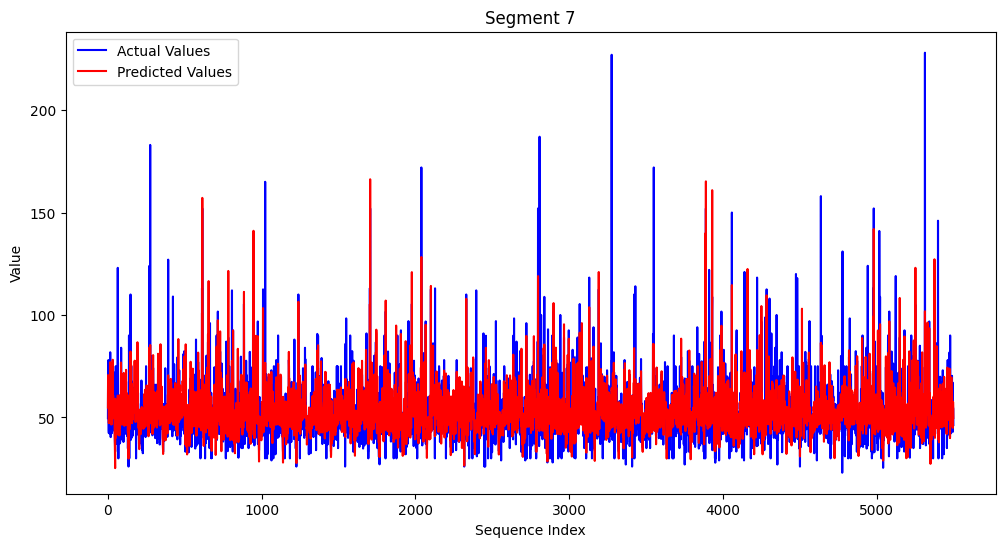

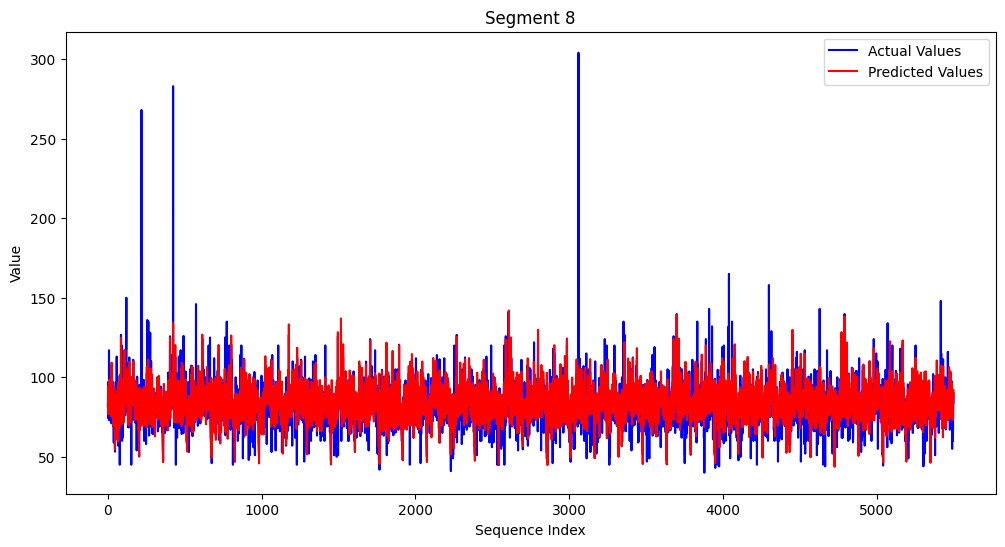

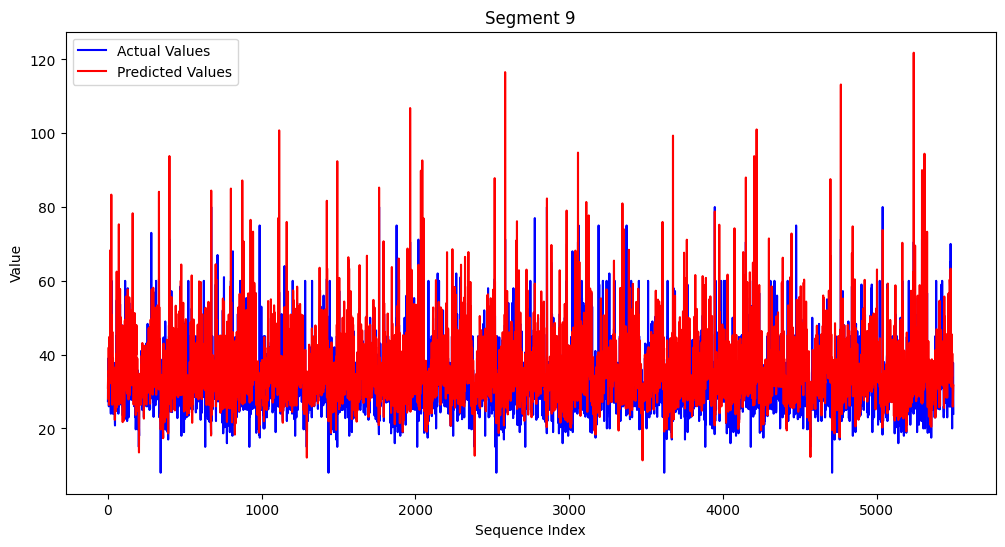

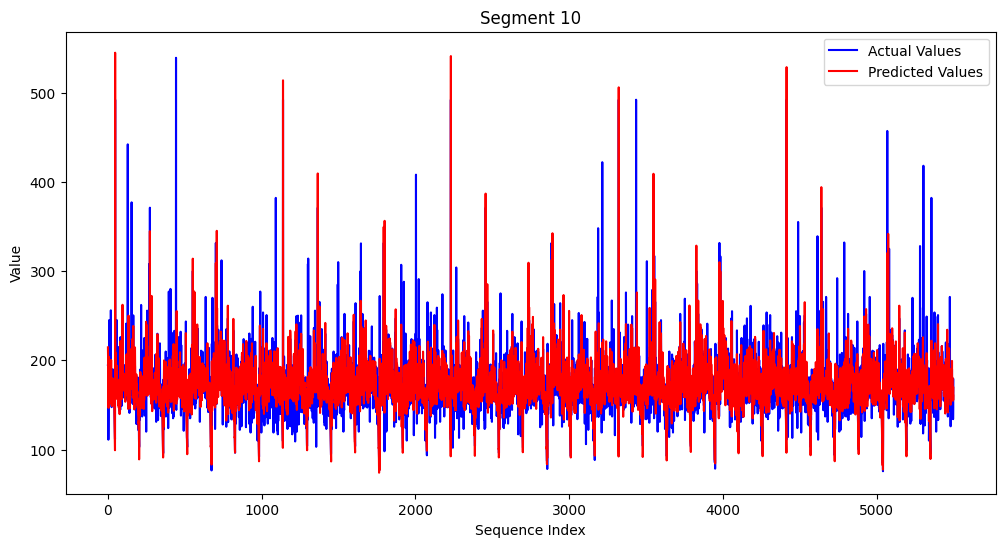

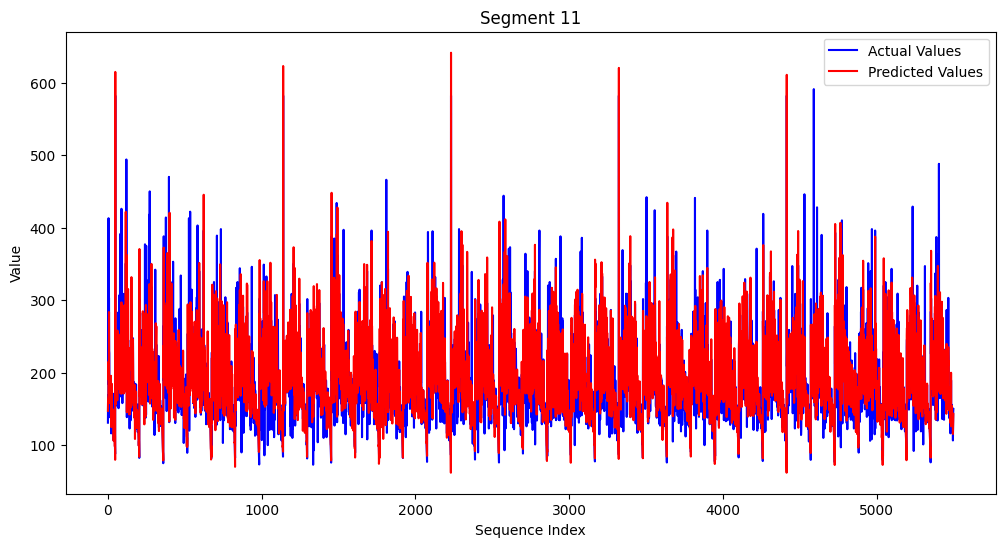

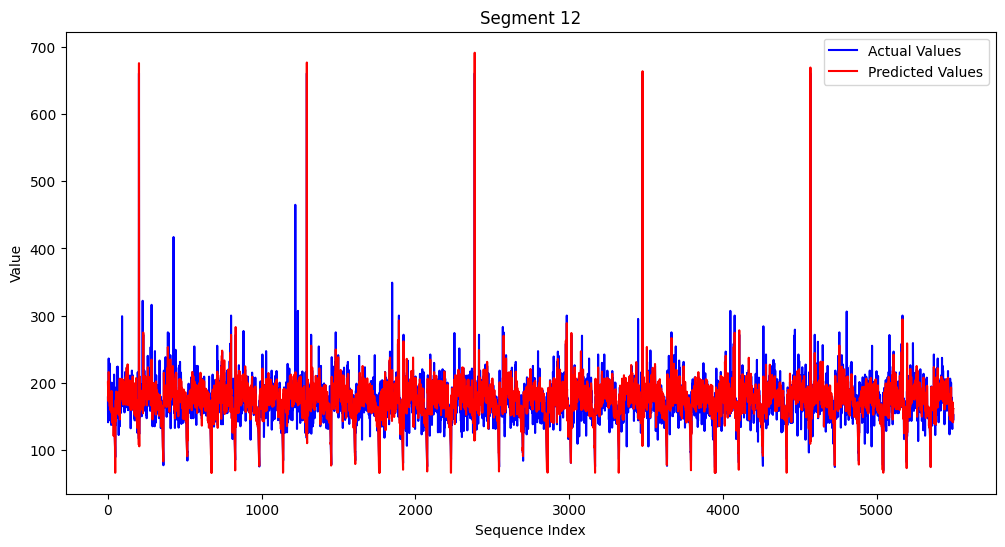

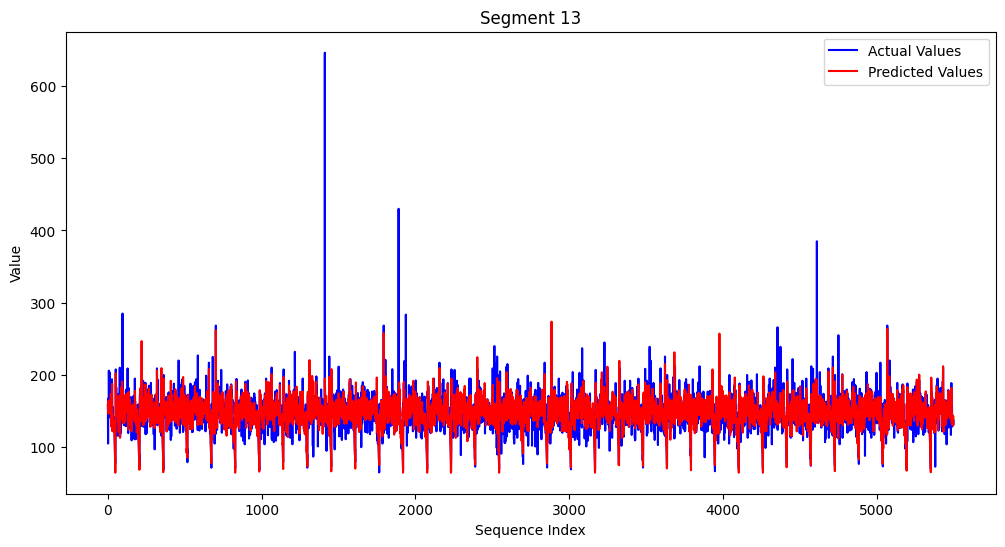

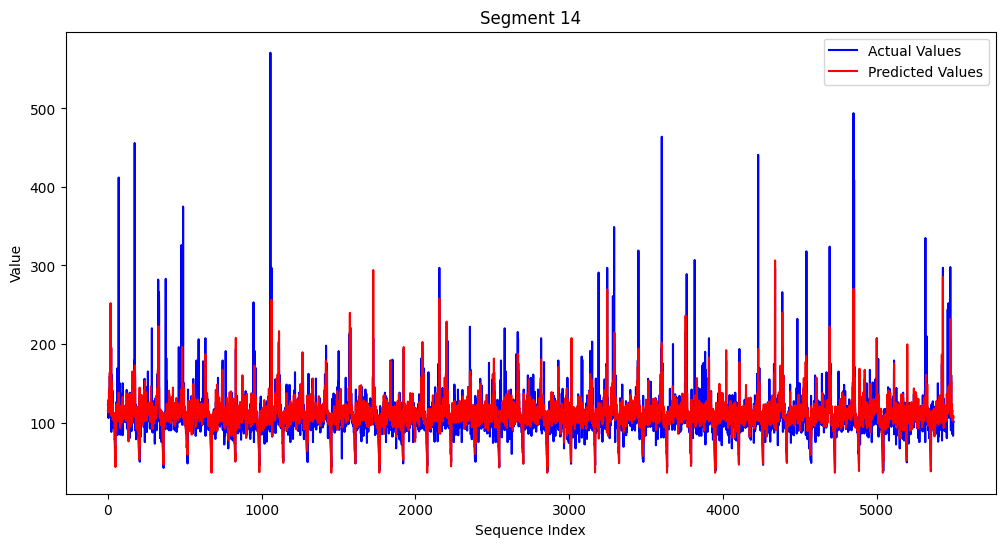

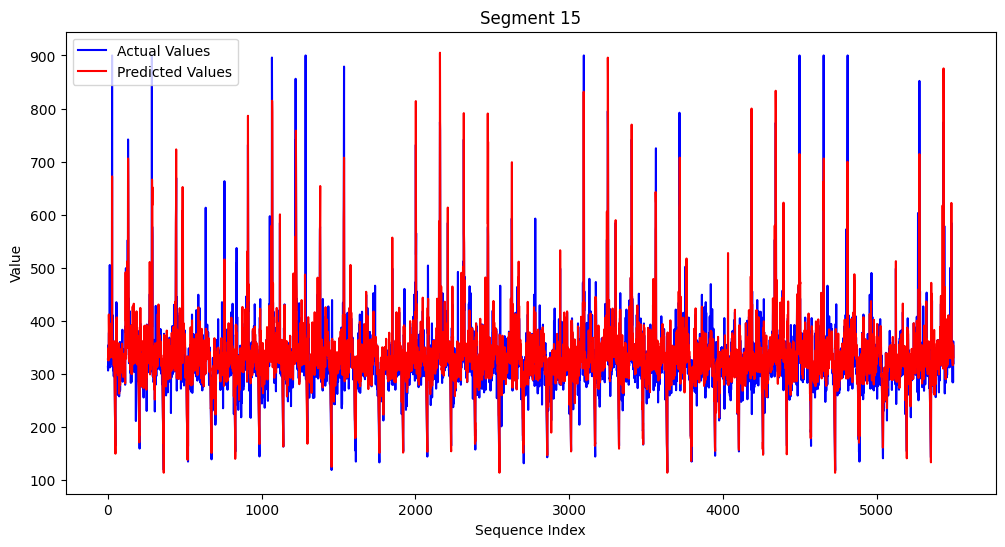

In [101]:
visualize_sorted_predictions(model2, test_loader2, device, scaling_params2)

In [102]:
r = 5

In [103]:
pred[r]

array([115.82266 , 217.59909 , 388.26868 , 226.44984 , 158.66174 ,
       244.13342 ,  48.893097,  83.63789 ,  41.933304, 204.01204 ,
       192.64328 , 215.85962 , 164.66486 , 126.63484 , 325.4231  ],
      dtype=float32)

In [104]:
trueVal[r]

array([106.909096, 209.27272 , 369.64255 , 203.      , 159.25    ,
       210.66666 ,  43.5     ,  77.8     ,  34.545456, 195.85    ,
       184.      , 236.      , 164.25    , 112.2     , 315.85715 ],
      dtype=float32)

In [105]:
dates_test[r]

numpy.datetime64('2022-09-27T16:00:00.000000000')

In [106]:
# Creating the DataFrame
column_names = ['DateTime'] + [f'{idx+1}' for idx in range(len(pred[0]))]
data = []

for date, pred_values in zip(dates_test, pred):
    row = [date] + pred_values.tolist()
    data.append(row)

df_combined = pd.DataFrame(data, columns=column_names)

df_combined

,DateTime,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2022-09-27 15:35:00,114.206993,261.205231,417.237579,226.707336,136.516006,310.576019,54.880325,82.245117,31.028740,214.513672,147.313477,200.394287,159.595764,122.647522,328.486755
1,2022-09-27 15:40:00,112.872131,242.588638,411.588837,226.127563,144.331604,264.386658,70.645981,94.320930,33.503330,196.901581,163.505249,191.031845,146.754730,122.754456,330.414459
2,2022-09-27 15:45:00,115.494293,250.811676,427.390228,217.193344,129.714447,248.956772,64.369873,76.893936,27.966278,190.044067,166.715179,201.826660,157.576355,117.712601,325.522644
3,2022-09-27 15:50:00,110.816582,232.105179,423.918610,216.244858,143.258942,306.515350,70.105515,90.855316,35.461426,181.373459,166.897980,188.462952,161.133362,128.676575,348.233521
4,2022-09-27 15:55:00,127.208405,286.956299,428.530090,237.020905,134.681152,309.140381,61.211060,93.058609,35.148781,146.664642,215.112122,172.314972,159.837097,112.643173,325.677917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,2022-11-01 18:35:00,112.004738,244.470444,474.658752,297.978760,132.551941,230.316055,44.876072,76.042198,25.924816,163.960815,135.123657,170.395294,139.020508,103.370789,316.172089
5497,2022-11-01 18:40:00,99.519501,201.189545,441.964478,289.169373,131.996231,224.971863,49.694641,79.203506,27.903942,154.674500,115.389160,142.213318,143.534027,106.608597,333.585266
5498,2022-11-01 18:45:00,96.885391,197.253983,431.090027,253.145508,147.152267,274.041595,57.525402,78.914200,30.401785,161.508667,125.880714,140.918106,132.560043,108.170334,317.644196
5499,2022-11-01 18:50:00,115.067230,190.920593,411.238861,238.561401,142.676025,225.675705,55.322220,92.170364,31.277496,155.332672,133.336151,160.673096,129.899277,104.663330,353.786591


In [120]:
initial = pd.read_csv("/content/drive/MyDrive/data/bus_running_times_feature_added_all.csv")

In [121]:
busses_new = initial[['trip_id','deviceid','direction','segment','date','start_time','end_time','run_time','run_time_in_seconds']]

In [122]:
busses_new.dropna(inplace=True)

<ipython-input-122-1dc632e7d6d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busses_new.dropna(inplace=True)


In [123]:
segments = 15
time_step = 5
previous_steps = 15
pred_steps = 1
min = 1
lag = 0
start_time = '06:00:00'
end_time = '19:00:00'

In [124]:
mask = busses_new['segment'] <= segments

In [125]:
busses_new = busses_new[mask]

In [126]:
# Extract only the time from 'end_time' column
busses_new['start_time_only'] = pd.to_datetime(busses_new['start_time']).dt.time

# Combine 'date' and the extracted time to create 'start_datetime'
busses_new['start_datetime'] = pd.to_datetime(busses_new['date'] + ' ' + busses_new['start_time_only'].astype(str))

# Display the first few rows to verify
busses_new[['date', 'start_time_only', 'start_datetime']].head()


,date,start_time_only,start_datetime
0,2021-10-01,06:39:49,2021-10-01 06:39:49
1,2021-10-01,06:42:12,2021-10-01 06:42:12
2,2021-10-01,06:45:42,2021-10-01 06:45:42
3,2021-10-01,06:54:04,2021-10-01 06:54:04
4,2021-10-01,06:57:19,2021-10-01 06:57:19


In [127]:
busses_new.head()

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,06:39:49,2021-10-01 06:39:49
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,06:42:12,2021-10-01 06:42:12
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,06:45:42,2021-10-01 06:45:42
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,06:54:04,2021-10-01 06:54:04
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,06:57:19,2021-10-01 06:57:19


In [128]:
# Loop through each row in busses_new
for index, row in busses_new.iterrows():
    # Get the end_datetime and segment values
    start_dt = row['start_datetime']
    segment = int(row['segment'])

    # Find the row in df_combined where start_datetime falls in the specified range
    mask = (df_combined['DateTime'] <= start_dt) & (df_combined['DateTime'] + pd.Timedelta(minutes=5) > start_dt)

    # If there's a matching row in df_combined
    if df_combined[mask].shape[0] > 0:
        # Get the predicted value using the segment number
        predicted_value = df_combined[mask].iloc[0][segment]

        # Assign the predicted value to the predicted_runTime column in busses_new
        busses_new.at[index, 'predicted_runTime'] = predicted_value
    else:
        busses_new.at[index, 'predicted_runTime'] = None

In [129]:
busses_new.dropna(inplace=True)

In [130]:
busses_new

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime,predicted_runTime
158396,23173.0,1166.0,1.0,10.0,2022-09-27,15:35:15,15:38:30,0:03:15,195.0,15:35:15,2022-09-27 15:35:15,214.513672
158397,23173.0,1166.0,1.0,11.0,2022-09-27,15:38:30,15:40:41,0:02:11,131.0,15:38:30,2022-09-27 15:38:30,147.313477
158398,23173.0,1166.0,1.0,12.0,2022-09-27,15:40:41,15:43:02,0:02:21,141.0,15:40:41,2022-09-27 15:40:41,191.031845
158399,23173.0,1166.0,1.0,13.0,2022-09-27,15:43:02,15:44:47,0:01:45,105.0,15:43:02,2022-09-27 15:43:02,146.754730
158400,23173.0,1166.0,1.0,14.0,2022-09-27,15:44:47,15:46:42,0:01:55,115.0,15:44:47,2022-09-27 15:44:47,122.754456
...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,18:47:53,2022-11-01 18:47:53,125.880714
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,18:50:15,2022-11-01 18:50:15,160.673096
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,18:52:50,2022-11-01 18:52:50,129.899277
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,18:55:14,2022-11-01 18:55:14,107.802032


In [161]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = busses_new['run_time_in_seconds']
predicted_values = busses_new['predicted_runTime']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 33.0372211921779
MSE: 2766.9879723860263
RMSE: 52.60216699325253


In [132]:
busses_new.to_csv('finalPred.csv', index=False)

In [160]:
busses_new

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime,predicted_runTime,hour
158396,23173.0,1166.0,1.0,10.0,2022-09-27,15:35:15,15:38:30,0:03:15,195.0,15:35:15,2022-09-27 15:35:15,214.513672,15
158397,23173.0,1166.0,1.0,11.0,2022-09-27,15:38:30,15:40:41,0:02:11,131.0,15:38:30,2022-09-27 15:38:30,147.313477,15
158398,23173.0,1166.0,1.0,12.0,2022-09-27,15:40:41,15:43:02,0:02:21,141.0,15:40:41,2022-09-27 15:40:41,191.031845,15
158399,23173.0,1166.0,1.0,13.0,2022-09-27,15:43:02,15:44:47,0:01:45,105.0,15:43:02,2022-09-27 15:43:02,146.754730,15
158400,23173.0,1166.0,1.0,14.0,2022-09-27,15:44:47,15:46:42,0:01:55,115.0,15:44:47,2022-09-27 15:44:47,122.754456,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,18:47:53,2022-11-01 18:47:53,125.880714,18
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,18:50:15,2022-11-01 18:50:15,160.673096,18
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,18:52:50,2022-11-01 18:52:50,129.899277,18
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,18:55:14,2022-11-01 18:55:14,107.802032,18


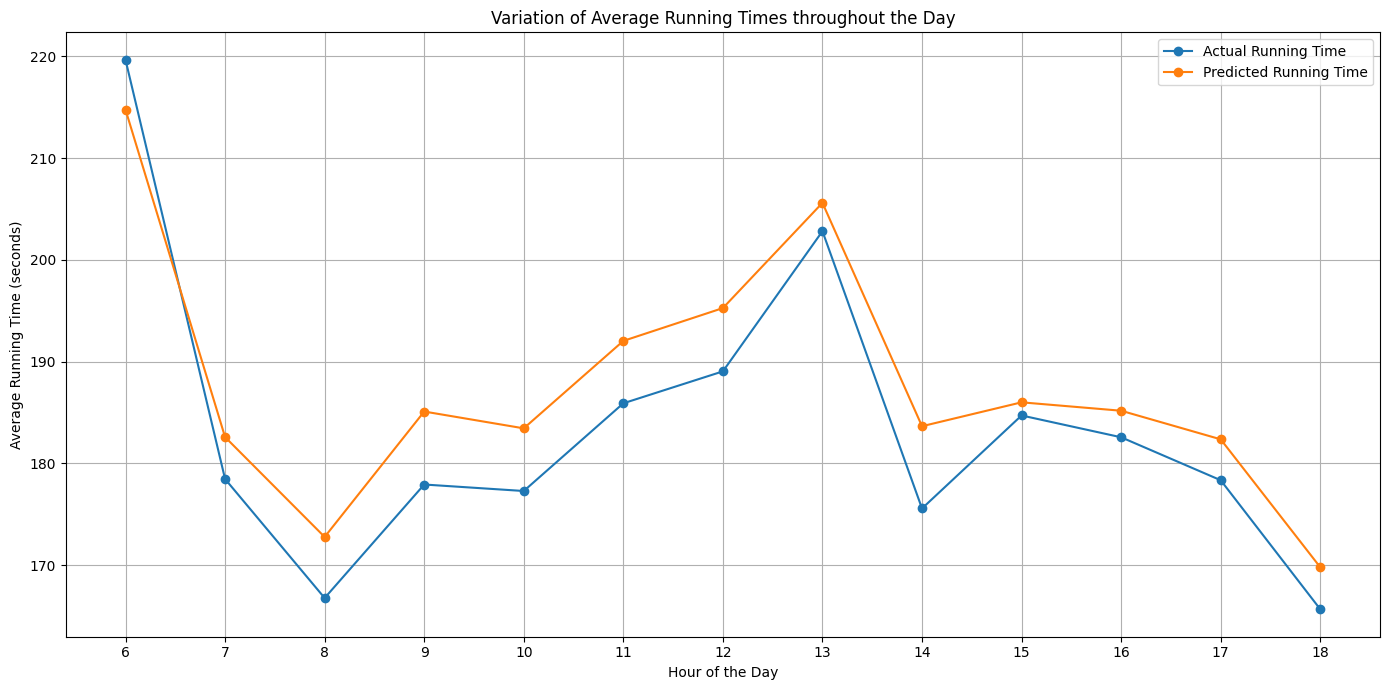

In [135]:
import matplotlib.pyplot as plt

data = busses_new
# Extract hour from the start_time column
data['hour'] = pd.to_datetime(data['start_time']).dt.hour

# Group by hour and calculate the average for both actual and predicted run times
grouped_data = data.groupby('hour').agg({
    'run_time_in_seconds': 'mean',
    'predicted_runTime': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(grouped_data['hour'], grouped_data['run_time_in_seconds'], label='Actual Running Time', marker='o')
plt.plot(grouped_data['hour'], grouped_data['predicted_runTime'], label='Predicted Running Time', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Running Time (seconds)')
plt.title('Variation of Average Running Times throughout the Day')
plt.legend()
plt.grid(True)
plt.xticks(grouped_data['hour'])
plt.tight_layout()
plt.show()


In [220]:
initial.columns

Index(['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time',
       'end_time', 'run_time', 'run_time_in_seconds', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'conditions', 'dt(n-1)'],
      dtype='object')

In [221]:
ds = initial.copy()
ds.dropna(inplace=True)
mask = ds['segment'] <= segments
ds.head()

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,...,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,...,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,...,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,...,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,...,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0


In [222]:
X_data = ds[['trip_id', 'deviceid', 'segment', 'run_time_in_seconds', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'conditions', 'dt(n-1)']]
y_data = ds['run_time_in_seconds']

In [223]:
X_data.head()

,trip_id,deviceid,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,...,rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
0,1.0,262.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,...,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
1,1.0,262.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,...,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0
2,1.0,262.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,...,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
3,1.0,262.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,...,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0
4,1.0,262.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,...,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0


In [224]:
y_data.head()

0     69.0
1    210.0
2    496.0
3    195.0
4     97.0
Name: run_time_in_seconds, dtype: float64

In [225]:
temp = busses_new.copy()

In [226]:
temp

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime,predicted_runTime,hour
158396,23173.0,1166.0,1.0,10.0,2022-09-27,15:35:15,15:38:30,0:03:15,195.0,15:35:15,2022-09-27 15:35:15,214.513672,15
158397,23173.0,1166.0,1.0,11.0,2022-09-27,15:38:30,15:40:41,0:02:11,131.0,15:38:30,2022-09-27 15:38:30,147.313477,15
158398,23173.0,1166.0,1.0,12.0,2022-09-27,15:40:41,15:43:02,0:02:21,141.0,15:40:41,2022-09-27 15:40:41,191.031845,15
158399,23173.0,1166.0,1.0,13.0,2022-09-27,15:43:02,15:44:47,0:01:45,105.0,15:43:02,2022-09-27 15:43:02,146.754730,15
158400,23173.0,1166.0,1.0,14.0,2022-09-27,15:44:47,15:46:42,0:01:55,115.0,15:44:47,2022-09-27 15:44:47,122.754456,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,18:47:53,2022-11-01 18:47:53,125.880714,18
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,18:50:15,2022-11-01 18:50:15,160.673096,18
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,18:52:50,2022-11-01 18:52:50,129.899277,18
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,18:55:14,2022-11-01 18:55:14,107.802032,18


In [227]:
# Columns to consider for the merge
common_columns = ['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time', 'end_time', 'run_time', 'run_time_in_seconds']

# Inner join 'ds' and 'temp' on the common columns
merged_df = ds.merge(temp, on=common_columns, how='inner')

merged_df

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,month,temp,precip,windspeed,conditions,dt(n-1),start_time_only,start_datetime,predicted_runTime,hour
0,23173.0,1166.0,1.0,10.0,2022-09-27,15:35:15,15:38:30,0:03:15,195.0,1.23,...,9.0,28.9,0.0,9.4,Overcast,60.0,15:35:15,2022-09-27 15:35:15,214.513672,15
1,23173.0,1166.0,1.0,11.0,2022-09-27,15:38:30,15:40:41,0:02:11,131.0,1.10,...,9.0,28.9,0.0,9.4,Overcast,0.0,15:38:30,2022-09-27 15:38:30,147.313477,15
2,23173.0,1166.0,1.0,12.0,2022-09-27,15:40:41,15:43:02,0:02:21,141.0,1.31,...,9.0,28.9,0.0,9.4,Overcast,0.0,15:40:41,2022-09-27 15:40:41,191.031845,15
3,23173.0,1166.0,1.0,13.0,2022-09-27,15:43:02,15:44:47,0:01:45,105.0,1.15,...,9.0,28.9,0.0,9.4,Overcast,0.0,15:43:02,2022-09-27 15:43:02,146.754730,15
4,23173.0,1166.0,1.0,14.0,2022-09-27,15:44:47,15:46:42,0:01:55,115.0,0.89,...,9.0,28.9,0.0,9.4,Overcast,0.0,15:44:47,2022-09-27 15:44:47,122.754456,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15320,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,1.10,...,11.0,20.5,0.0,8.3,Overcast,15.0,18:47:53,2022-11-01 18:47:53,125.880714,18
15321,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,1.31,...,11.0,20.5,0.0,8.3,Overcast,7.0,18:50:15,2022-11-01 18:50:15,160.673096,18
15322,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,1.15,...,11.0,20.5,0.0,8.3,Overcast,11.0,18:52:50,2022-11-01 18:52:50,129.899277,18
15323,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,0.89,...,11.0,20.5,0.0,8.3,Overcast,13.0,18:55:14,2022-11-01 18:55:14,107.802032,18


In [228]:
ds_not_in_merged = ds.merge(merged_df, on=common_columns, how='left', indicator=True).query('_merge == "left_only" ')

In [229]:
ds_not_in_merged

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length_x,...,temp_y,precip_y,windspeed_y,conditions_y,dt(n-1)_y,start_time_only,start_datetime,predicted_runTime,hour,_merge
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200674,25367.0,1377.0,2.0,30.0,2022-11-01,18:17:36,18:24:21,0:06:45,405.0,2.5600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
200675,25367.0,1377.0,2.0,31.0,2022-11-01,18:24:21,18:25:36,0:01:15,75.0,0.4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
200676,25367.0,1377.0,2.0,32.0,2022-11-01,18:25:49,18:28:10,0:02:21,141.0,1.3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
200677,25367.0,1377.0,2.0,33.0,2022-11-01,18:28:10,18:31:25,0:03:15,195.0,1.2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only


In [230]:
ds_not_in_merged.columns

Index(['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time',
       'end_time', 'run_time', 'run_time_in_seconds', 'length_x',
       'day_of_week_x', 'time_of_day_x', 'Sunday/holiday_x', 'saturday_x',
       'weekday/end_x', 'week_no_x', 'rt(w-1)_x', 'rt(w-2)_x', 'rt(w-3)_x',
       'rt(t-1)_x', 'rt(t-2)_x', 'rt(n-1)_x', 'rt(n-2)_x', 'rt(n-3)_x',
       'hour_of_day_x', 'day_x', 'month_x', 'temp_x', 'precip_x',
       'windspeed_x', 'conditions_x', 'dt(n-1)_x', 'length_y', 'day_of_week_y',
       'time_of_day_y', 'Sunday/holiday_y', 'saturday_y', 'weekday/end_y',
       'week_no_y', 'rt(w-1)_y', 'rt(w-2)_y', 'rt(w-3)_y', 'rt(t-1)_y',
       'rt(t-2)_y', 'rt(n-1)_y', 'rt(n-2)_y', 'rt(n-3)_y', 'hour_of_day_y',
       'day_y', 'month_y', 'temp_y', 'precip_y', 'windspeed_y', 'conditions_y',
       'dt(n-1)_y', 'start_time_only', 'start_datetime', 'predicted_runTime',
       'hour', '_merge'],
      dtype='object')

In [231]:
X_train = ds_not_in_merged[['deviceid','segment', 'length_x',
       'day_of_week_x', 'time_of_day_x', 'Sunday/holiday_x', 'saturday_x',
       'weekday/end_x', 'week_no_x', 'rt(w-1)_x', 'rt(w-2)_x', 'rt(w-3)_x',
       'rt(t-1)_x', 'rt(t-2)_x', 'rt(n-1)_x', 'rt(n-2)_x', 'rt(n-3)_x',
       'hour_of_day_x', 'day_x', 'month_x', 'temp_x', 'precip_x',
       'windspeed_x', 'dt(n-1)_x']]

# Define a mapping of the old column names to the new column names
column_mapping = {
    'deviceid': 'deviceid',
    'segment': 'segment',
    'length_x': 'length',
    'day_of_week_x': 'day_of_week',
    'time_of_day_x': 'time_of_day',
    'Sunday/holiday_x': 'Sunday/holiday',
    'saturday_x': 'saturday',
    'weekday/end_x': 'weekday/end',
    'week_no_x': 'week_no',
    'rt(w-1)_x': 'rt(w-1)',
    'rt(w-2)_x': 'rt(w-2)',
    'rt(w-3)_x': 'rt(w-3)',
    'rt(t-1)_x': 'rt(t-1)',
    'rt(t-2)_x': 'rt(t-2)',
    'rt(n-1)_x': 'rt(n-1)',
    'rt(n-2)_x': 'rt(n-2)',
    'rt(n-3)_x': 'rt(n-3)',
    'hour_of_day_x': 'hour_of_day',
    'day_x': 'day',
    'month_x': 'month',
    'temp_x': 'temp',
    'precip_x': 'precip',
    'windspeed_x': 'windspeed',
    'dt(n-1)_x': 'dt(n-1)'
}

# Rename the columns in X_train
X_train.rename(columns=column_mapping, inplace=True)

y_train = ds_not_in_merged['run_time_in_seconds']

<ipython-input-231-1d530d5e8ca4>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.rename(columns=column_mapping, inplace=True)


In [232]:
X_train.head()

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1)
0,262.0,1.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,...,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,0.0
1,262.0,2.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,...,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,74.0
2,262.0,3.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,...,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,0.0
3,262.0,4.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,...,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,6.0
4,262.0,5.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,...,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,0.0


In [233]:
X_test = merged_df[['deviceid', 'segment', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'dt(n-1)']]

y_test = merged_df['run_time_in_seconds']
nn_pred = merged_df['predicted_runTime']

In [234]:
import xgboost as xgb

# Assuming X_train and y_train are your data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Specify the parameters for the XGBoost regressor
params = {
    'objective': 'reg:squarederror',  # Specify regression as the task
    'tree_method': 'gpu_hist',  # Use GPU accelerated algorithm
}

# Train the model
model = xgb.train(params, dtrain)

# Now your model is trained and ready to make predictions!


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:45:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [235]:
# Assuming X_test and y_test are your test data
dtest = xgb.DMatrix(X_test)

# Use the trained model to make predictions
y_pred = model.predict(dtest)


In [236]:
X_test['run_time_in_seconds'] = y_test
X_test['xgbPred'] = y_pred
X_test['NNPred'] = nn_pred



<ipython-input-236-5b4ea7f4998a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['run_time_in_seconds'] = y_test
<ipython-input-236-5b4ea7f4998a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['xgbPred'] = y_pred
<ipython-input-236-5b4ea7f4998a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [237]:
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,hour_of_day,day,month,temp,precip,windspeed,dt(n-1),run_time_in_seconds,xgbPred,NNPred
0,1166.0,10.0,1.23,1.0,15.50,0.0,0,1,37.0,205.0,...,15.0,27.0,9.0,28.9,0.0,9.4,60.0,195.0,194.054916,214.513672
1,1166.0,11.0,1.10,1.0,15.50,0.0,0,1,37.0,206.0,...,15.0,27.0,9.0,28.9,0.0,9.4,0.0,131.0,198.006912,147.313477
2,1166.0,12.0,1.31,1.0,15.50,0.0,0,1,37.0,195.0,...,15.0,27.0,9.0,28.9,0.0,9.4,0.0,141.0,206.775223,191.031845
3,1166.0,13.0,1.15,1.0,15.50,0.0,0,1,37.0,148.0,...,15.0,27.0,9.0,28.9,0.0,9.4,0.0,105.0,149.079102,146.754730
4,1166.0,14.0,0.89,1.0,15.50,0.0,0,1,37.0,157.0,...,15.0,27.0,9.0,28.9,0.0,9.4,0.0,115.0,133.161575,122.754456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15320,121.0,11.0,1.10,1.0,18.75,0.0,0,1,42.0,150.0,...,18.0,1.0,11.0,20.5,0.0,8.3,15.0,135.0,152.201096,125.880714
15321,121.0,12.0,1.31,1.0,18.75,0.0,0,1,42.0,165.0,...,18.0,1.0,11.0,20.5,0.0,8.3,7.0,144.0,151.833496,160.673096
15322,121.0,13.0,1.15,1.0,18.75,0.0,0,1,42.0,139.0,...,18.0,1.0,11.0,20.5,0.0,8.3,11.0,131.0,130.201401,129.899277
15323,121.0,14.0,0.89,1.0,18.75,0.0,0,1,42.0,102.0,...,18.0,1.0,11.0,20.5,0.0,8.3,13.0,101.0,102.042961,107.802032


In [238]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['run_time_in_seconds']
predicted_values = X_test['xgbPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE xgbPred: {mae}")
print(f"MSE xgbPred: {mse}")
print(f"RMSE xgbPred: {rmse}")


MAE xgbPred: 33.91205396692671
MSE xgbPred: 2921.2377842340497
RMSE xgbPred: 54.04847624340625


In [239]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['run_time_in_seconds']
predicted_values = X_test['NNPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE NNPred: {mae}")
print(f"MSE NNPred: {mse}")
print(f"RMSE NNPred: {rmse}")


MAE NNPred: 33.0372211921779
MSE NNPred: 2766.9879723860263
RMSE NNPred: 52.60216699325253


In [240]:
X_test['avgPred'] = (X_test['xgbPred'] + X_test['NNPred'])/2

<ipython-input-240-478536fea46f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avgPred'] = (X_test['xgbPred'] + X_test['NNPred'])/2


In [241]:
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,day,month,temp,precip,windspeed,dt(n-1),run_time_in_seconds,xgbPred,NNPred,avgPred
0,1166.0,10.0,1.23,1.0,15.50,0.0,0,1,37.0,205.0,...,27.0,9.0,28.9,0.0,9.4,60.0,195.0,194.054916,214.513672,204.284294
1,1166.0,11.0,1.10,1.0,15.50,0.0,0,1,37.0,206.0,...,27.0,9.0,28.9,0.0,9.4,0.0,131.0,198.006912,147.313477,172.660194
2,1166.0,12.0,1.31,1.0,15.50,0.0,0,1,37.0,195.0,...,27.0,9.0,28.9,0.0,9.4,0.0,141.0,206.775223,191.031845,198.903534
3,1166.0,13.0,1.15,1.0,15.50,0.0,0,1,37.0,148.0,...,27.0,9.0,28.9,0.0,9.4,0.0,105.0,149.079102,146.754730,147.916916
4,1166.0,14.0,0.89,1.0,15.50,0.0,0,1,37.0,157.0,...,27.0,9.0,28.9,0.0,9.4,0.0,115.0,133.161575,122.754456,127.958015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15320,121.0,11.0,1.10,1.0,18.75,0.0,0,1,42.0,150.0,...,1.0,11.0,20.5,0.0,8.3,15.0,135.0,152.201096,125.880714,139.040905
15321,121.0,12.0,1.31,1.0,18.75,0.0,0,1,42.0,165.0,...,1.0,11.0,20.5,0.0,8.3,7.0,144.0,151.833496,160.673096,156.253296
15322,121.0,13.0,1.15,1.0,18.75,0.0,0,1,42.0,139.0,...,1.0,11.0,20.5,0.0,8.3,11.0,131.0,130.201401,129.899277,130.050339
15323,121.0,14.0,0.89,1.0,18.75,0.0,0,1,42.0,102.0,...,1.0,11.0,20.5,0.0,8.3,13.0,101.0,102.042961,107.802032,104.922497


In [242]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['run_time_in_seconds']
predicted_values = X_test['avgPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE avgPred: {mae}")
print(f"MSE avgPred: {mse}")
print(f"RMSE avgPred: {rmse}")


MAE avgPred: 31.682306307283934
MSE avgPred: 2537.257269610189
RMSE avgPred: 50.371194840009395


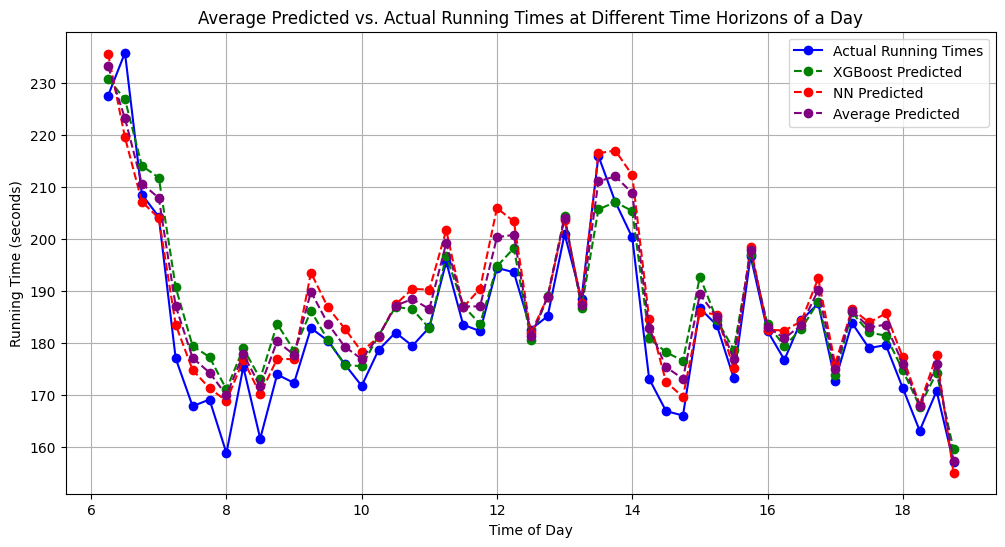

In [243]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named X_test with the provided dataset

# Group the data by time_of_day and calculate the mean for each group
grouped = X_test.groupby('time_of_day').mean()

# Extract the time_of_day and actual running times
time_of_day = grouped.index
actual_running_times = grouped['run_time_in_seconds']
xgb_pred = grouped['xgbPred']
nn_pred = grouped['NNPred']
avg_pred = grouped['avgPred']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, actual_running_times, label='Actual Running Times', marker='o', linestyle='-', color='blue')
plt.plot(time_of_day, xgb_pred, label='XGBoost Predicted', marker='o', linestyle='--', color='green')
plt.plot(time_of_day, nn_pred, label='NN Predicted', marker='o', linestyle='--', color='red')
plt.plot(time_of_day, avg_pred, label='Average Predicted', marker='o', linestyle='--', color='purple')

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Running Time (seconds)')
plt.title('Average Predicted vs. Actual Running Times at Different Time Horizons of a Day')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [244]:
X_test.columns

Index(['deviceid', 'segment', 'length', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'rt(w-1)',
       'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)', 'rt(n-2)',
       'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'dt(n-1)', 'run_time_in_seconds', 'xgbPred', 'NNPred', 'avgPred'],
      dtype='object')

In [245]:
ensemble_X = X_test[['deviceid', 'segment', 'length', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'rt(w-1)',
       'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)', 'rt(n-2)',
       'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'dt(n-1)',  'xgbPred', 'NNPred', 'avgPred']]
ensemble_y = X_test['run_time_in_seconds']

In [252]:
# from sklearn.model_selection import train_test_split
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(ensemble_X, ensemble_y, test_size=0.3, random_state=42)

# # Initialize the XGBoost regressor
# xgb_regressor = XGBRegressor()

# # Train the regressor on the training data
# xgb_regressor.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = xgb_regressor.predict(X_test)

# # Calculate the Mean Absolute Error (MAE) on the test set
# mae = mean_absolute_error(y_test, y_pred)

# # Print the MAE
# print(f"Mean Absolute Error (MAE): {mae}")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ensemble_X, ensemble_y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Train the regressor on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate the Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(y_test, y_pred)

# Print the MAE
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 29.398520951138178


In [253]:
X_test['ensemble'] = y_pred
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,day,month,temp,precip,windspeed,dt(n-1),xgbPred,NNPred,avgPred,ensemble
10498,284.0,7.0,0.37,4.0,16.25,0.0,0,1,40.0,50.0,...,21.0,10.0,21.2,0.000,8.6,31.0,55.900360,55.906628,55.903494,53.31
7434,505.0,15.0,1.97,4.0,16.50,0.0,0,1,39.0,391.0,...,14.0,10.0,22.3,0.000,8.6,25.0,353.008728,400.709686,376.859207,335.46
6497,121.0,2.0,1.28,3.0,7.25,0.0,0,1,39.0,276.0,...,13.0,10.0,20.7,0.000,5.0,15.0,256.793945,277.744354,267.269150,283.68
3445,123.0,5.0,0.84,2.0,10.25,0.0,0,1,38.0,134.0,...,5.0,10.0,24.8,0.000,9.0,0.0,131.123810,138.147705,134.635757,128.66
11972,1377.0,15.0,1.97,1.0,11.00,0.0,0,1,41.0,327.0,...,25.0,10.0,27.5,0.029,1.8,15.0,298.747528,303.239594,300.993561,300.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,121.0,11.0,1.10,0.0,14.00,0.0,0,1,38.0,181.0,...,3.0,10.0,26.0,0.600,2.2,15.0,182.078308,198.757721,190.418015,184.35
3338,1143.0,1.0,0.63,2.0,7.00,0.0,0,1,38.0,81.0,...,5.0,10.0,19.5,0.000,7.2,0.0,119.048347,110.156784,114.602566,119.59
6459,262.0,9.0,0.26,3.0,7.25,0.0,0,1,39.0,38.0,...,13.0,10.0,20.7,0.000,5.0,4.0,40.171814,31.778185,35.974999,30.47
3353,275.0,1.0,0.63,2.0,7.25,0.0,0,1,38.0,101.0,...,5.0,10.0,19.5,0.000,7.2,0.0,110.369926,99.932098,105.151012,99.32


In [254]:
X_test['run_time_in_seconds'] = y_test
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,month,temp,precip,windspeed,dt(n-1),xgbPred,NNPred,avgPred,ensemble,run_time_in_seconds
10498,284.0,7.0,0.37,4.0,16.25,0.0,0,1,40.0,50.0,...,10.0,21.2,0.000,8.6,31.0,55.900360,55.906628,55.903494,53.31,27.0
7434,505.0,15.0,1.97,4.0,16.50,0.0,0,1,39.0,391.0,...,10.0,22.3,0.000,8.6,25.0,353.008728,400.709686,376.859207,335.46,464.0
6497,121.0,2.0,1.28,3.0,7.25,0.0,0,1,39.0,276.0,...,10.0,20.7,0.000,5.0,15.0,256.793945,277.744354,267.269150,283.68,303.0
3445,123.0,5.0,0.84,2.0,10.25,0.0,0,1,38.0,134.0,...,10.0,24.8,0.000,9.0,0.0,131.123810,138.147705,134.635757,128.66,121.0
11972,1377.0,15.0,1.97,1.0,11.00,0.0,0,1,41.0,327.0,...,10.0,27.5,0.029,1.8,15.0,298.747528,303.239594,300.993561,300.74,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,121.0,11.0,1.10,0.0,14.00,0.0,0,1,38.0,181.0,...,10.0,26.0,0.600,2.2,15.0,182.078308,198.757721,190.418015,184.35,164.0
3338,1143.0,1.0,0.63,2.0,7.00,0.0,0,1,38.0,81.0,...,10.0,19.5,0.000,7.2,0.0,119.048347,110.156784,114.602566,119.59,105.0
6459,262.0,9.0,0.26,3.0,7.25,0.0,0,1,39.0,38.0,...,10.0,20.7,0.000,5.0,4.0,40.171814,31.778185,35.974999,30.47,31.0
3353,275.0,1.0,0.63,2.0,7.25,0.0,0,1,38.0,101.0,...,10.0,19.5,0.000,7.2,0.0,110.369926,99.932098,105.151012,99.32,73.0


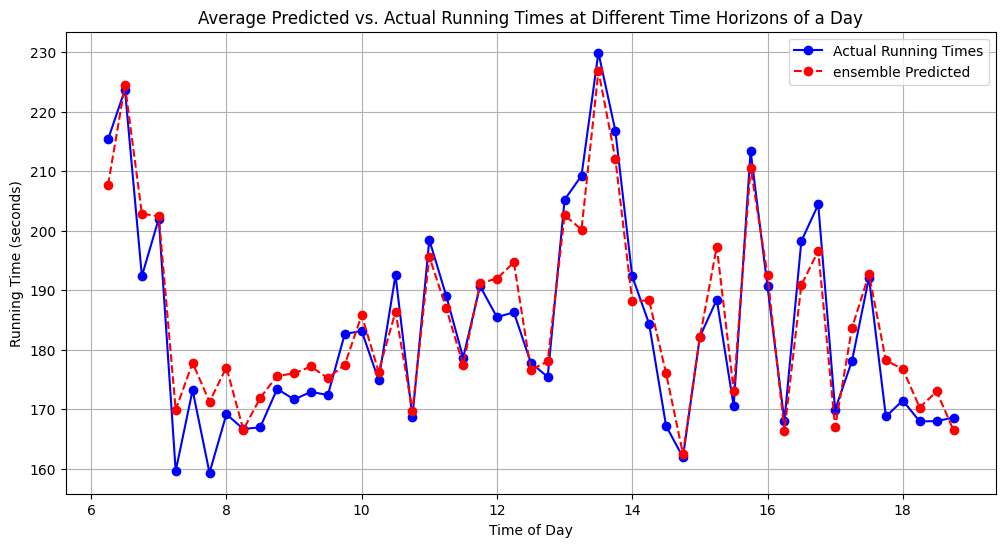

In [255]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named X_test with the provided dataset

# Group the data by time_of_day and calculate the mean for each group
grouped = X_test.groupby('time_of_day').mean()

# Extract the time_of_day and actual running times
time_of_day = grouped.index
actual_running_times = grouped['run_time_in_seconds']
xgb_pred = grouped['xgbPred']
nn_pred = grouped['NNPred']
avg_pred = grouped['ensemble']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, actual_running_times, label='Actual Running Times', marker='o', linestyle='-', color='blue')
# plt.plot(time_of_day, xgb_pred, label='XGBoost Predicted', marker='o', linestyle='--', color='green')
# plt.plot(time_of_day, nn_pred, label='NN Predicted', marker='o', linestyle='--', color='red')
plt.plot(time_of_day, avg_pred, label='ensemble Predicted', marker='o', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Running Time (seconds)')
plt.title('Average Predicted vs. Actual Running Times at Different Time Horizons of a Day')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()
